**Import required packages**

In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression , LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import statsmodels.api as sm
from mord import LogisticIT
import matplotlib.pylab as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
from dmba import regressionSummary, classificationSummary, exhaustive_search
from dmba import liftChart, gainsChart
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score
from dmba import plotDecisionTree
from scipy.stats import skew

**Load data**

In [2]:
# Load data
cars_df = pd.read_csv("cars.csv")
print(cars_df)

             ID                                               Name   Price  \
0      11530130                  2010 Toyota Rukus Build 2 AZE151R    9999   
1      12190570  2021 Mercedes-Benz V 250 D Avantgarde MWB 447 ...  117990   
2      12321855  2021 Mercedes-Benz Valente 116 CDI MWB RWD 447...   79990   
3      12346971         2010 Mercedes-Benz E250 CDI Avantgarde 207   34990   
4      12363884                       2016 Holden Cruze CD JH MY16   15990   
...         ...                                                ...     ...   
17043  12852453                 2003 Holden Commodore Executive VY    4499   
17044  12852460                        2008 Toyota Yaris YR NCP90R    4999   
17045  12852462               2002 Holden Jackaroo SE LWB (4X4) U8    7999   
17046  12852463               2016 Hyundai I30 Active GD4 Series 2   14000   
17047  12852464              2005 Toyota RAV4 Cruiser (4X4) ACA23R    5999   

               Brand      Model               Variant        Se

In [3]:
cars_df.dtypes

ID                   int64
Name                object
Price                int64
Brand               object
Model               object
Variant             object
Series              object
Year                 int64
Kilometers           int64
Type                object
Gearbox             object
Fuel                object
Status              object
CC                   int64
Color               object
Seating Capacity     int64
dtype: object

**Rename columns: replace spaces with '_'**

In [4]:
# Rename columns: replace spaces with '_’
cars_df = cars_df.rename (columns={'Seating Capacity': 'Seating_Capacity'})
# explicit
cars_df.columns = [s.strip ().replace(' ','_') for s in cars_df.columns] #all columns
cars_df.head(9)

,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating_Capacity
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,Used,2362,Grey,5
1,12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 ...,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel,New In Stock,2143,Black,7
2,12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447...,79990,Mercedes-Benz,Valente,116 CDI MWB RWD,447 MY21,2021,24,Wagon,Automatic,Diesel,New In Stock,2143,Black,8
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,Used,2143,Black,4
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,Used,1796,White,5
5,12366036,2017 Nissan X-Trail ST (4WD) T32 Series 2,26800,Nissan,X-Trail,ST (4WD),T32 Series 2,2017,121870,Wagon,Automatic,Unleaded Petrol,Used,2488,White,5
6,12370057,2016 Ford Territory TX (rwd) SZ MK2,23990,Ford,Territory,TX (rwd),SZ MK2,2016,154136,Wagon,Automatic,Diesel,Used,2720,White,5
7,12381448,2011 BMW 325I Exclusive E90 MY11,18990,BMW,325I,Exclusive,E90 MY11,2011,117306,Sedan,Automatic,Premium Unleaded Petrol,Used,2497,Grey,5
8,12382945,2005 Holden Statesman International WL,15490,Holden,Statesman,International,WL,2005,172151,Sedan,Automatic,Unleaded Petrol,Used,5665,Blue,5


**Data reduction - remove New In Stock and Demo cars from "Status" column**

In [5]:
cars_df = cars_df[~cars_df['Status'].isin([' New In Stock', ' Demo'])]
cars_df

,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating_Capacity
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,Used,2362,Grey,5
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,Used,2143,Black,4
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,Used,1796,White,5
5,12366036,2017 Nissan X-Trail ST (4WD) T32 Series 2,26800,Nissan,X-Trail,ST (4WD),T32 Series 2,2017,121870,Wagon,Automatic,Unleaded Petrol,Used,2488,White,5
6,12370057,2016 Ford Territory TX (rwd) SZ MK2,23990,Ford,Territory,TX (rwd),SZ MK2,2016,154136,Wagon,Automatic,Diesel,Used,2720,White,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17043,12852453,2003 Holden Commodore Executive VY,4499,Holden,Commodore,Executive,VY,2003,230441,Sedan,Automatic,Unleaded Petrol,Used,3791,Gold,5
17044,12852460,2008 Toyota Yaris YR NCP90R,4999,Toyota,Yaris,YR,NCP90R,2008,237113,Hatchback,Manual,Unleaded Petrol,Used,1299,Yellow,5
17045,12852462,2002 Holden Jackaroo SE LWB (4X4) U8,7999,Holden,Jackaroo,SE LWB (4X4),U8,2002,238768,Wagon,Automatic,Diesel,Used,2999,Gold,7
17046,12852463,2016 Hyundai I30 Active GD4 Series 2,14000,Hyundai,I30,Active,GD4 Series 2,2016,49800,Hatchback,Manual,Unleaded Petrol,Used,1797,Blue,5


**Dimension Reduction - drop "Status" column as only used cars are present in dataset**

In [6]:
cars_df.drop(columns=['Status'], inplace=True)
cars_df.head(9)

,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,CC,Color,Seating_Capacity
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,2362,Grey,5
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,2143,Black,4
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,1796,White,5
5,12366036,2017 Nissan X-Trail ST (4WD) T32 Series 2,26800,Nissan,X-Trail,ST (4WD),T32 Series 2,2017,121870,Wagon,Automatic,Unleaded Petrol,2488,White,5
6,12370057,2016 Ford Territory TX (rwd) SZ MK2,23990,Ford,Territory,TX (rwd),SZ MK2,2016,154136,Wagon,Automatic,Diesel,2720,White,5
7,12381448,2011 BMW 325I Exclusive E90 MY11,18990,BMW,325I,Exclusive,E90 MY11,2011,117306,Sedan,Automatic,Premium Unleaded Petrol,2497,Grey,5
8,12382945,2005 Holden Statesman International WL,15490,Holden,Statesman,International,WL,2005,172151,Sedan,Automatic,Unleaded Petrol,5665,Blue,5
9,12382946,2003 Holden Commodore Berlina Vyii,15490,Holden,Commodore,Berlina,Vyii,2003,186990,Sedan,Automatic,Unleaded Petrol,5665,Green,5
10,12382955,2015 Isuzu D-MAX SX (4X2) TF MY15,15490,Isuzu,D-MAX,SX (4X2),TF MY15,2015,231907,Cab Chassis,Manual,Diesel,2999,White,2


**Create a new column called "Age" to calculate the age of the car from the year of manufacture**

In [7]:
import datetime
# Calculate Age
def age(year):
    current_year = datetime.date.today().year
    return current_year - year
cars_df['Age'] = cars_df['Year'].apply(age)
age_and_year = cars_df.loc[:, ['Year', 'Age']]
print(age_and_year)

       Year  Age
0      2010   13
3      2010   13
4      2016    7
5      2017    6
6      2016    7
...     ...  ...
17043  2003   20
17044  2008   15
17045  2002   21
17046  2016    7
17047  2005   18

[16304 rows x 2 columns]


**Create a new column to categorize price of the used cars**

In [8]:
cars_df['Price_Classification'] = ['Not Fair' if price > 39279 else 'Fair' for price in cars_df['Price']]
cars_df['Price_Classification'].value_counts()['Fair']

11109

In [9]:
cars_df['Price_Classification'].value_counts()['Not Fair']

5195

In [10]:
cars_df['Price_Classification_Numerical'] = cars_df['Price_Classification'].replace({'Fair': 0, 'Not Fair': 1})
cars_df['Price_Classification_Numerical'].value_counts()[0]

11109

In [11]:
cars_df['Price_Classification_Numerical'].value_counts()[1]

5195

In [12]:
cars_df.head(9)

,ID,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,CC,Color,Seating_Capacity,Age,Price_Classification,Price_Classification_Numerical
0,11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,2362,Grey,5,13,Fair,0
3,12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,2143,Black,4,13,Fair,0
4,12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,1796,White,5,7,Fair,0
5,12366036,2017 Nissan X-Trail ST (4WD) T32 Series 2,26800,Nissan,X-Trail,ST (4WD),T32 Series 2,2017,121870,Wagon,Automatic,Unleaded Petrol,2488,White,5,6,Fair,0
6,12370057,2016 Ford Territory TX (rwd) SZ MK2,23990,Ford,Territory,TX (rwd),SZ MK2,2016,154136,Wagon,Automatic,Diesel,2720,White,5,7,Fair,0
7,12381448,2011 BMW 325I Exclusive E90 MY11,18990,BMW,325I,Exclusive,E90 MY11,2011,117306,Sedan,Automatic,Premium Unleaded Petrol,2497,Grey,5,12,Fair,0
8,12382945,2005 Holden Statesman International WL,15490,Holden,Statesman,International,WL,2005,172151,Sedan,Automatic,Unleaded Petrol,5665,Blue,5,18,Fair,0
9,12382946,2003 Holden Commodore Berlina Vyii,15490,Holden,Commodore,Berlina,Vyii,2003,186990,Sedan,Automatic,Unleaded Petrol,5665,Green,5,20,Fair,0
10,12382955,2015 Isuzu D-MAX SX (4X2) TF MY15,15490,Isuzu,D-MAX,SX (4X2),TF MY15,2015,231907,Cab Chassis,Manual,Diesel,2999,White,2,8,Fair,0


**Identifying missing data**

In [13]:
cars_df.isnull().sum()

ID                                0
Name                              0
Price                             0
Brand                             0
Model                             0
Variant                           0
Series                            0
Year                              0
Kilometers                        0
Type                              0
Gearbox                           0
Fuel                              0
CC                                0
Color                             0
Seating_Capacity                  0
Age                               0
Price_Classification              0
Price_Classification_Numerical    0
dtype: int64

**Explore Variables with statistics**

In [14]:
cars_df.describe()

,ID,Price,Year,Kilometers,CC,Seating_Capacity,Age,Price_Classification_Numerical
count,1.630400e+04,16304.000000,16304.000000,1.630400e+04,16304.000000,16304.000000,16304.000000,16304.000000
mean,1.279023e+07,35638.707250,2015.194921,1.077969e+05,2507.482888,5.112058,7.805079,0.318633
std,5.015717e+04,29747.384168,4.619341,7.918173e+04,889.220960,1.131003,4.619341,0.465961
min,1.153013e+07,1000.000000,1989.000000,5.000000e+00,875.000000,2.000000,1.000000,0.000000
25%,1.275666e+07,17990.000000,2013.000000,5.058525e+04,1991.000000,5.000000,5.000000,0.000000
50%,1.280205e+07,29888.000000,2016.000000,9.248850e+04,2359.000000,5.000000,7.000000,0.000000
75%,1.283119e+07,44405.000000,2018.000000,1.520000e+05,2982.000000,5.000000,10.000000,1.000000
max,1.285246e+07,999000.000000,2022.000000,2.700000e+06,7300.000000,14.000000,34.000000,1.000000


In [15]:
pd.DataFrame({'mean': cars_df.select_dtypes(include=['int64', 'float64']).mean(),
              'Sd': cars_df.select_dtypes(include=['int64', 'float64']).std(),
              'min': cars_df.select_dtypes(include=['int64', 'float64']).min(),
              'max': cars_df.select_dtypes(include=['int64', 'float64']).max(),
              'median': cars_df.select_dtypes(include=['int64', 'float64']).median(),
              'length': len(cars_df.select_dtypes(include=['int64', 'float64'])),
              'miss.val': cars_df.select_dtypes(include=['int64', 'float64']).isnull().sum(),
             })

,mean,Sd,min,max,median,length,miss.val
ID,1.279023e+07,50157.165127,11530130,12852464,12802050.5,16304,0
Price,3.563871e+04,29747.384168,1000,999000,29888.0,16304,0
Year,2.015195e+03,4.619341,1989,2022,2016.0,16304,0
Kilometers,1.077969e+05,79181.728718,5,2700000,92488.5,16304,0
CC,2.507483e+03,889.220960,875,7300,2359.0,16304,0
Seating_Capacity,5.112058e+00,1.131003,2,14,5.0,16304,0
Age,7.805079e+00,4.619341,1,34,7.0,16304,0
Price_Classification_Numerical,3.186335e-01,0.465961,0,1,0.0,16304,0


**Explore Price variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of Price variable in Histogram')]

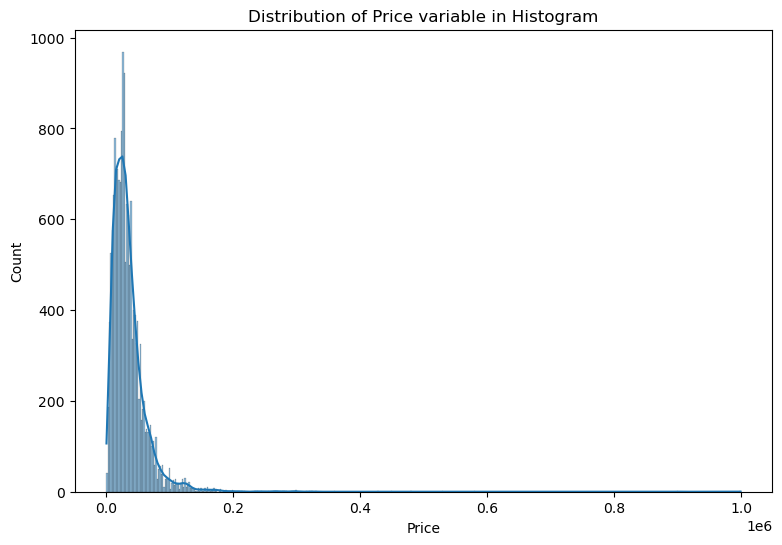

In [16]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='Price',
             kde=True).set(title='Distribution of Price variable in Histogram')  

In [17]:
#Finding skewness value
skew(cars_df['Price'])

6.888574540851314

Text(0.5, 1.0, 'Distribution of Price variable in Boxplot')

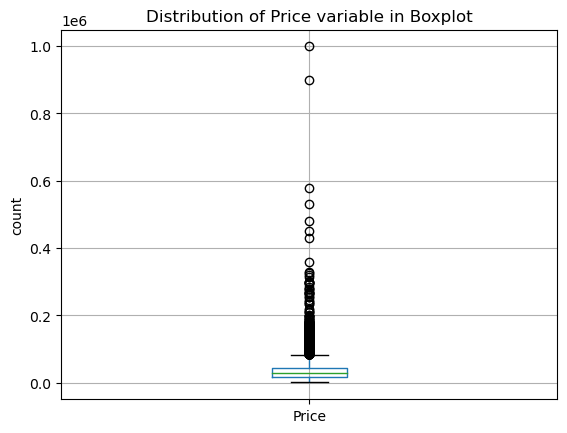

In [18]:
# Building boxplot
ax = cars_df.boxplot (column='Price')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of Price variable in Boxplot')

**Explore Year variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of Year variable in Histogram')]

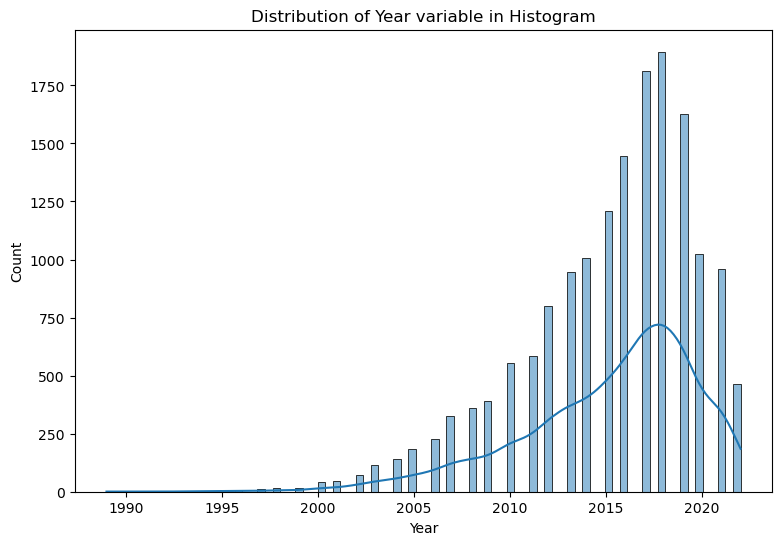

In [19]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='Year',
             kde=True).set(title='Distribution of Year variable in Histogram')  

In [20]:
#Finding skewness value
skew(cars_df['Year'])

-1.0577249003592728

Text(0.5, 1.0, 'Distribution of Year variable in Boxplot')

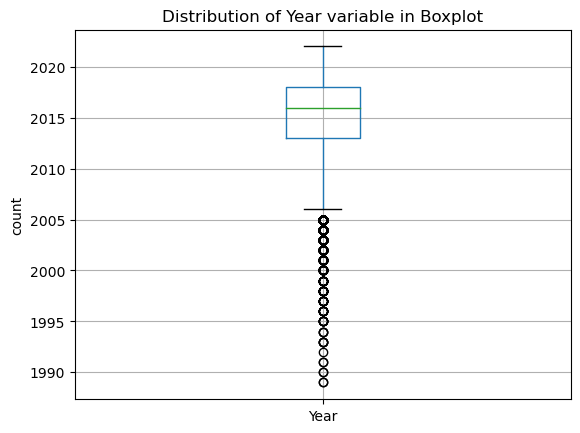

In [21]:
# Building boxplot
ax = cars_df.boxplot (column='Year')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of Year variable in Boxplot')

**Explore Kilometers variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of Kilometers variable in Histogram')]

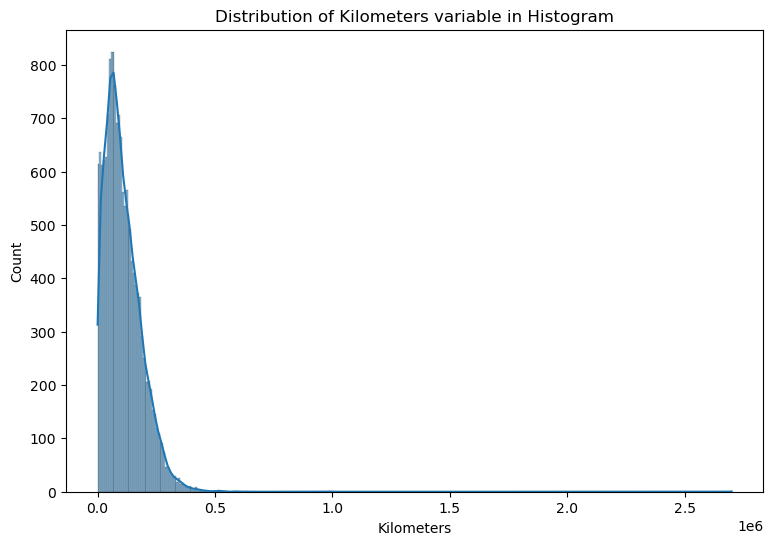

In [22]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='Kilometers',
             kde=True).set(title='Distribution of Kilometers variable in Histogram')  

In [23]:
#Finding skewness value
skew(cars_df['Kilometers'])

3.1588072519874837

Text(0.5, 1.0, 'Distribution of Kilometers variable in Boxplot')

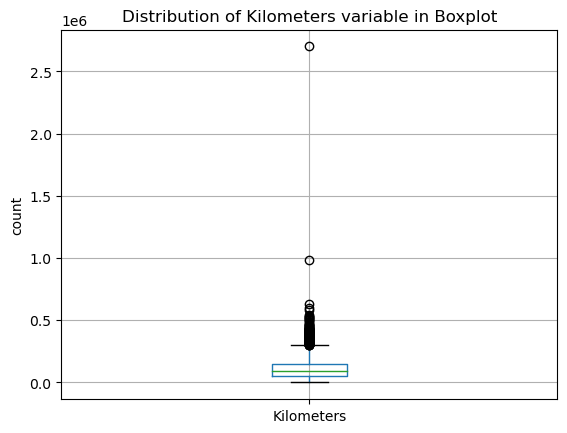

In [24]:
# Building boxplot
ax = cars_df.boxplot (column='Kilometers')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of Kilometers variable in Boxplot')

**Explore CC variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of CC variable in Histogram')]

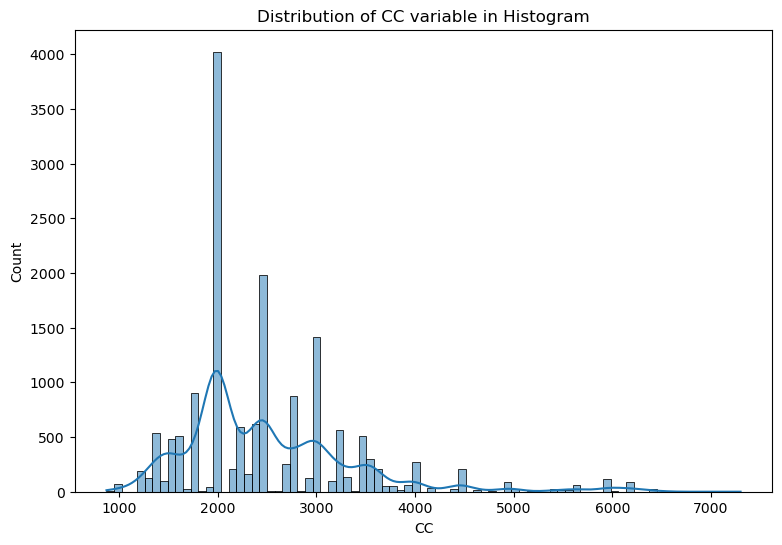

In [25]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='CC',
             kde=True).set(title='Distribution of CC variable in Histogram')  

In [26]:
#Finding skewness value
skew(cars_df['CC'])

1.57413815258633

Text(0.5, 1.0, 'Distribution of CC variable in Boxplot')

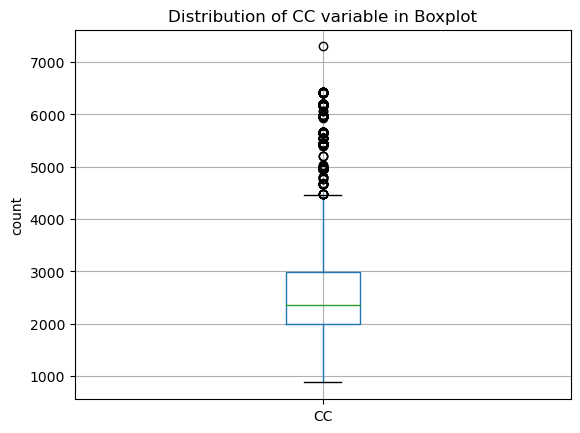

In [27]:
# Building boxplot
ax = cars_df.boxplot (column='CC')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of CC variable in Boxplot')

**Explore Seating_Capacity variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of Seating_Capacity variable in Histogram')]

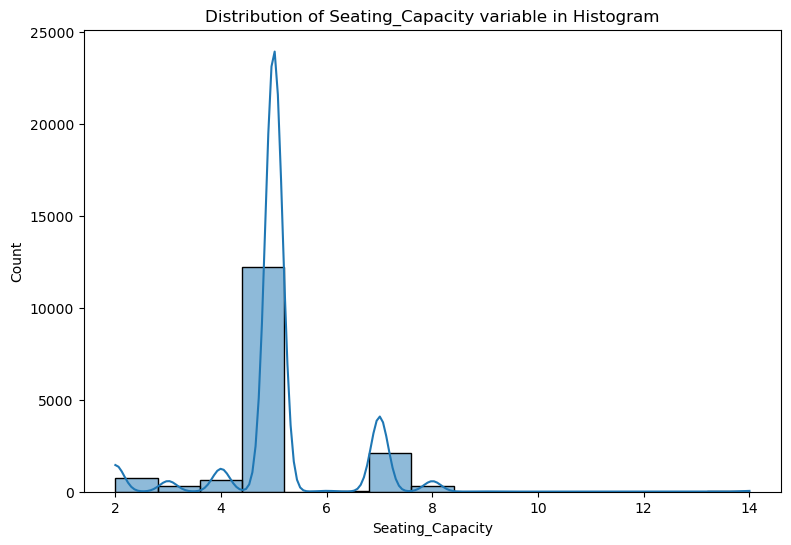

In [28]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='Seating_Capacity',
             kde=True).set(title='Distribution of Seating_Capacity variable in Histogram')  

In [29]:
#Finding skewness value
skew(cars_df['Seating_Capacity'])

0.396657448965431

Text(0.5, 1.0, 'Distribution of Seating_Capacity variable in Boxplot')

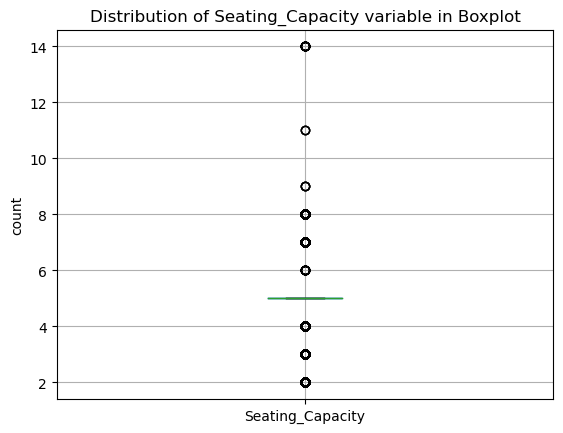

In [30]:
# Building boxplot
ax = cars_df.boxplot (column='Seating_Capacity')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of Seating_Capacity variable in Boxplot')

**Explore Age variable with histogram and boxplot**

[Text(0.5, 1.0, 'Distribution of Age variable in Histogram')]

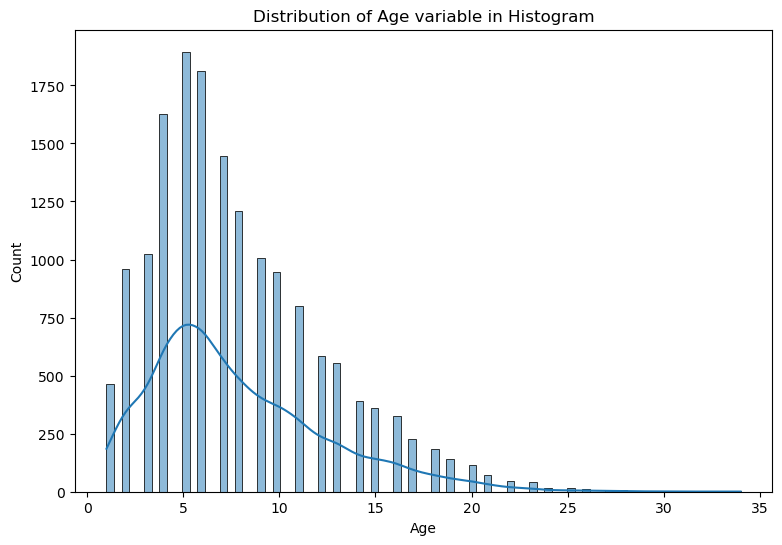

In [31]:
# Building histogram
plt.figure(figsize=(9,6))
sns.histplot(cars_df, x='Age',
             kde=True).set(title='Distribution of Age variable in Histogram')  

In [32]:
#Finding skewness value
skew(cars_df['Age'])

1.0577249003592437

Text(0.5, 1.0, 'Distribution of Age variable in Boxplot')

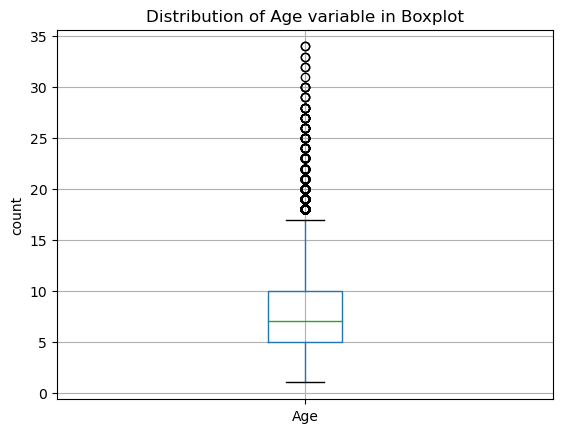

In [33]:
# Building boxplot
ax = cars_df.boxplot (column='Age')
ax.set_xlabel(''); ax.set_ylabel('count');
plt.suptitle('')
plt.title('Distribution of Age variable in Boxplot')

**Explore overall variables in boxplot**

<AxesSubplot:>

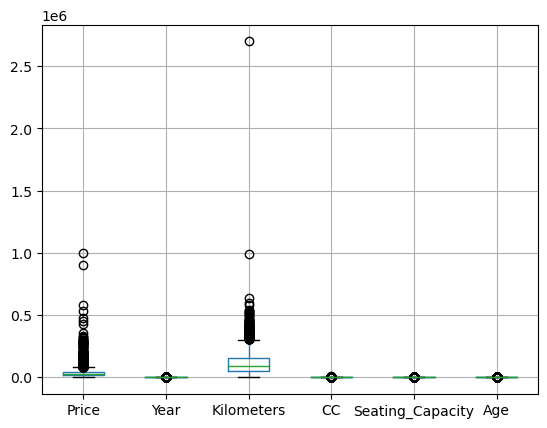

In [34]:
variables = ['Price','Year','Kilometers','CC','Seating_Capacity','Age']
cars_df.boxplot(column=variables)

**Finding outliers in Price variable**

In [35]:
# C. Computing interquartile range for outliers
# Remove outliers in Price variable
for x in ['Price']:
    q75,q25 = np.percentile(cars_df.loc[:,x],[75,25])
    inter_quartile_range = q75-q25
max = q75+(1.5*inter_quartile_range)
min = q25-(1.5*inter_quartile_range)
print(max, min)
cars_df.loc[cars_df[x] < min,x] = np.nan
cars_df.loc[cars_df[x] > max,x] = np.nan

84027.5 -21632.5


**Finding outliers in Kilometers variable**

In [36]:
# C. Computing interquartile range for outliers
# Remove outliers in Kilometers variable
for x in ['Kilometers']:
    q75,q25 = np.percentile(cars_df.loc[:,x],[75,25])
    inter_quartile_range = q75-q25
max = q75+(1.5*inter_quartile_range)
min = q25-(1.5*inter_quartile_range)
print(max, min)
cars_df.loc[cars_df[x] < min,x] = np.nan
cars_df.loc[cars_df[x] > max,x] = np.nan

304122.125 -101536.875


**Finding outliers in CC variable**

In [37]:
# C. Computing interquartile range for outliers
# Remove outliers in CC variable
for x in ['CC']:
    q75,q25 = np.percentile(cars_df.loc[:,x],[75,25])
    inter_quartile_range = q75-q25
max = q75+(1.5*inter_quartile_range)
min = q25-(1.5*inter_quartile_range)
print(max, min)
cars_df.loc[cars_df[x] < min,x] = np.nan
cars_df.loc[cars_df[x] > max,x] = np.nan

4468.5 504.5


**Remove outliers by omission**

In [38]:
# C. Data cleansing - Omission
# Remove rows with missing values
cars_df = cars_df.dropna().reset_index(drop=True)
print ('Number of rows after removing rows with missing values: ', len(cars_df))

Number of rows after removing rows with missing values:  14894


In [39]:
cars_df.isnull().sum()

ID                                0
Name                              0
Price                             0
Brand                             0
Model                             0
Variant                           0
Series                            0
Year                              0
Kilometers                        0
Type                              0
Gearbox                           0
Fuel                              0
CC                                0
Color                             0
Seating_Capacity                  0
Age                               0
Price_Classification              0
Price_Classification_Numerical    0
dtype: int64

**Explore variables with boxplots after removing outliers**

<AxesSubplot:>

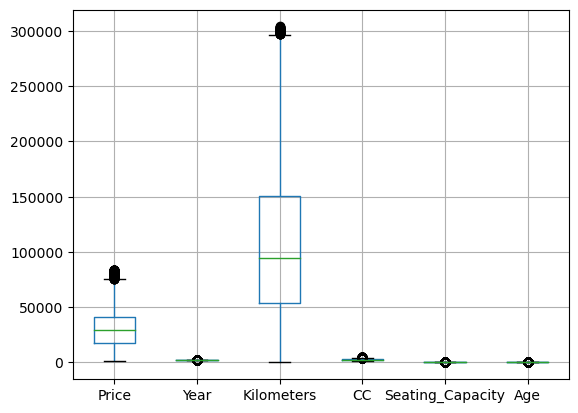

In [40]:
cars_df.boxplot(column=variables)

**Insights gained from visualization**

Text(0.5, 1.0, 'Average Price of Used Cars per Year')

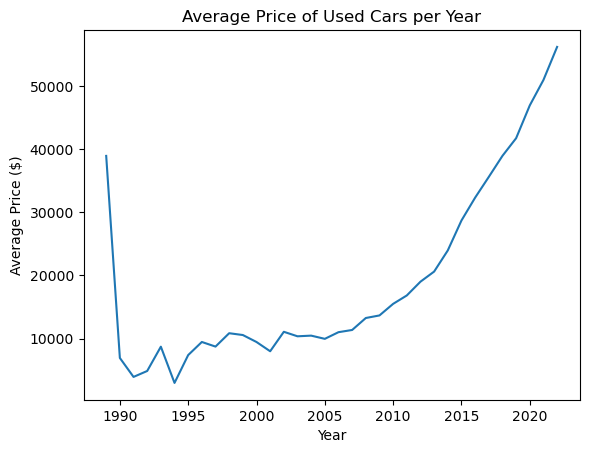

In [41]:
plt.plot(cars_df.groupby('Year')['Price'].mean())
plt.xlabel('Year'); plt.ylabel('Average Price ($)')
plt.title('Average Price of Used Cars per Year')

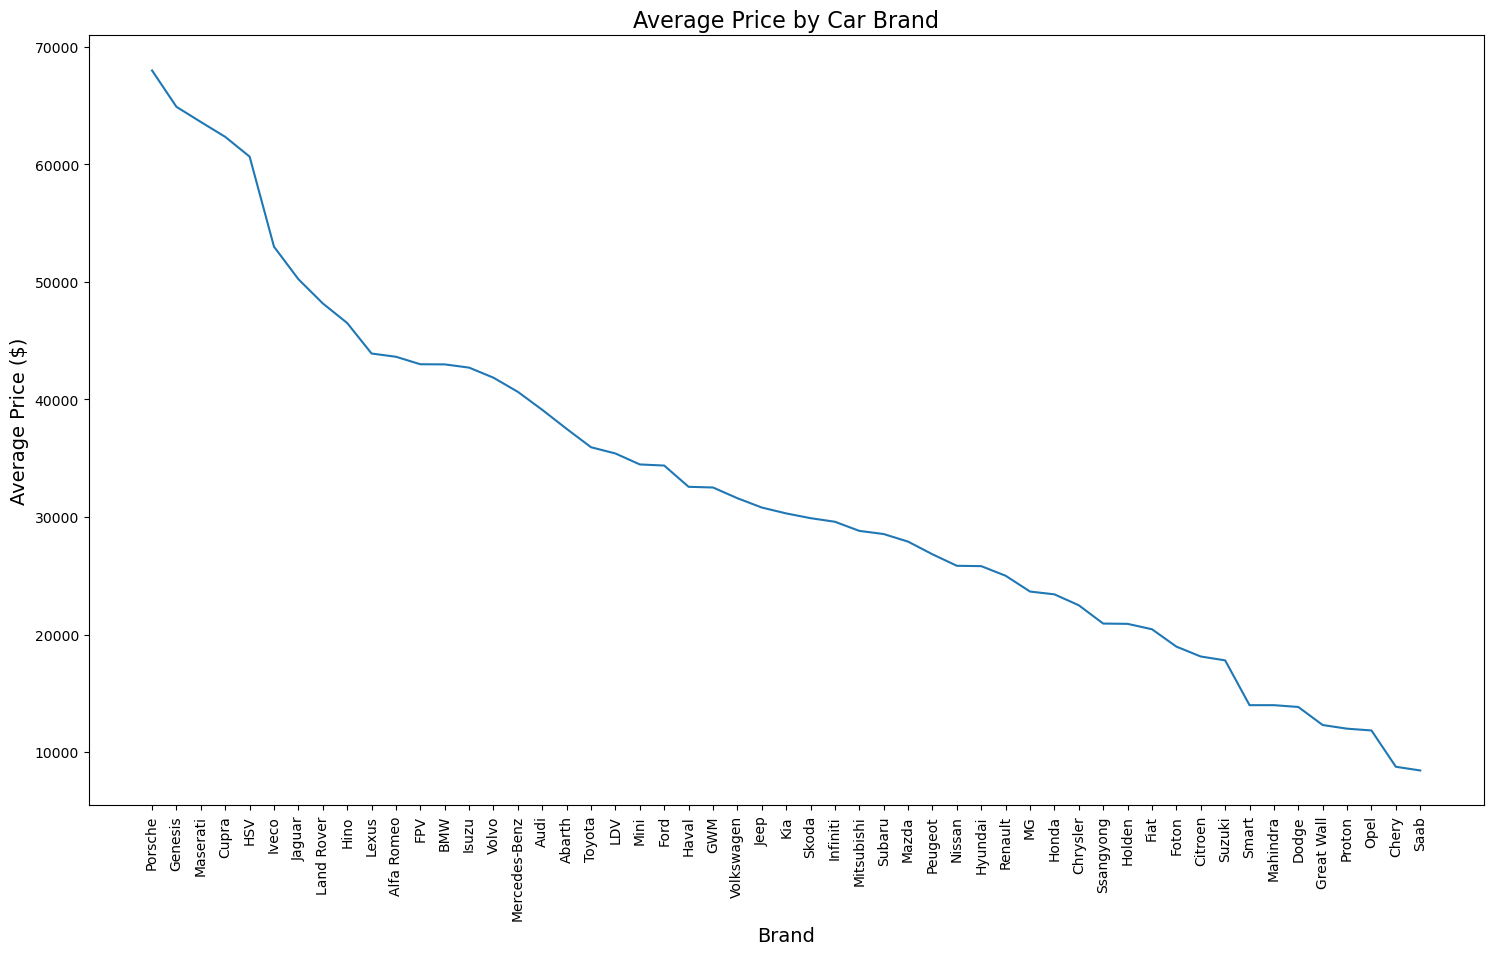

In [42]:
AvgBrandPrice = cars_df.groupby(['Brand'])['Price'].mean().reset_index().sort_values(by='Price',ascending=False)
plt.figure(figsize=(18,10))
plt.xticks(rotation=90)
plt.plot(AvgBrandPrice['Brand'],AvgBrandPrice['Price'])
plt.xlabel('Brand', fontsize=14)
plt.ylabel('Average Price ($)', fontsize=14)
plt.title('Average Price by Car Brand', fontsize=16)
plt.show()

Text(0.5, 1.0, 'Average Price by Gearbox')

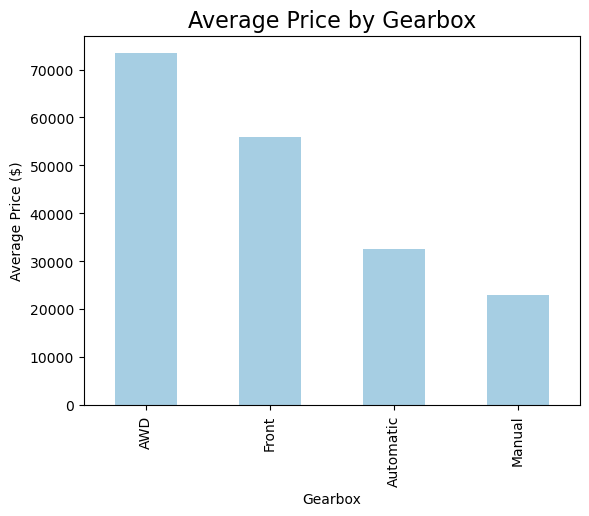

In [43]:
ax = cars_df.groupby('Gearbox').mean().Price.sort_values(ascending=False)
fig = ax.plot(kind='bar', stacked=True, colormap='Paired')
fig.set_ylabel('Average Price ($)')
plt.title('Average Price by Gearbox', fontsize=16)

Text(0.5, 1.0, 'Average Price by Fuel Type')

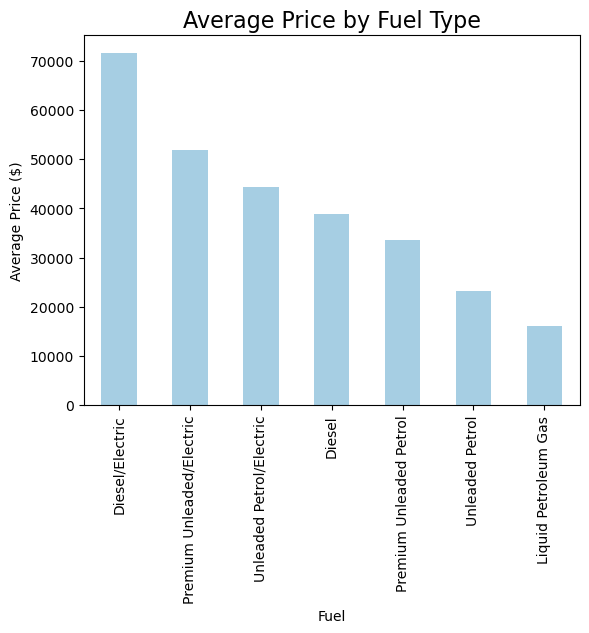

In [44]:
ax = cars_df.groupby('Fuel').mean().Price.sort_values(ascending=False)
fig = ax.plot(kind='bar', stacked=True, colormap='Paired')
fig.set_ylabel('Average Price ($)')
plt.title('Average Price by Fuel Type', fontsize=16)

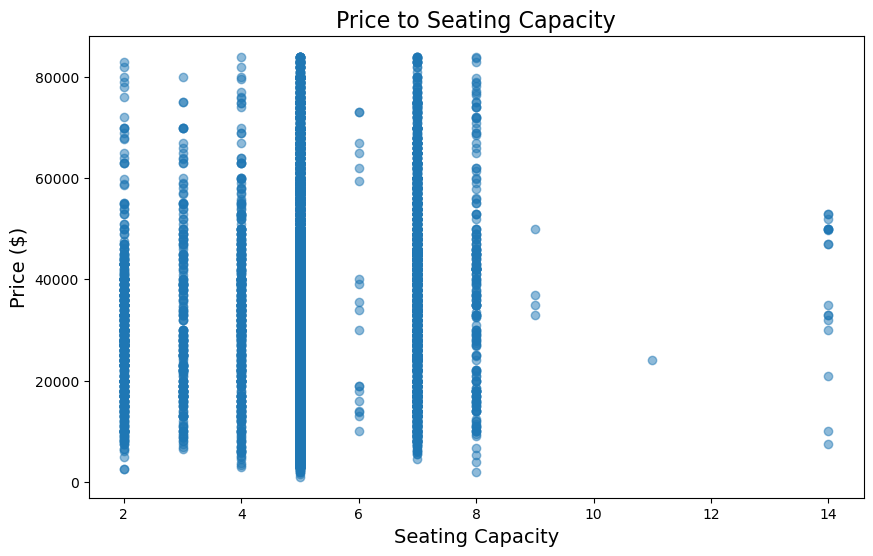

In [45]:
plt.figure(figsize=(10,6))
plt.scatter(cars_df['Seating_Capacity'], cars_df['Price'], alpha=0.5)
plt.xlabel('Seating Capacity', fontsize=14)
plt.ylabel('Price ($)', fontsize=14)
plt.title('Price to Seating Capacity', fontsize=16)
plt.show()

**Explore correlation between variables**

In [46]:
#Find the correlation between each pair of columns
cars_df.corr().round(2)

,ID,Price,Year,Kilometers,CC,Seating_Capacity,Age,Price_Classification_Numerical
ID,1.00,-0.05,-0.00,-0.01,-0.05,0.01,0.00,-0.04
Price,-0.05,1.00,0.67,-0.56,0.18,0.13,-0.67,0.81
Year,-0.00,0.67,1.00,-0.71,-0.18,0.05,-1.00,0.46
Kilometers,-0.01,-0.56,-0.71,1.00,0.27,-0.03,0.71,-0.41
CC,-0.05,0.18,-0.18,0.27,1.00,0.10,0.18,0.18
Seating_Capacity,0.01,0.13,0.05,-0.03,0.10,1.00,-0.05,0.15
Age,0.00,-0.67,-1.00,0.71,0.18,-0.05,1.00,-0.46
Price_Classification_Numerical,-0.04,0.81,0.46,-0.41,0.18,0.15,-0.46,1.00


<AxesSubplot:>

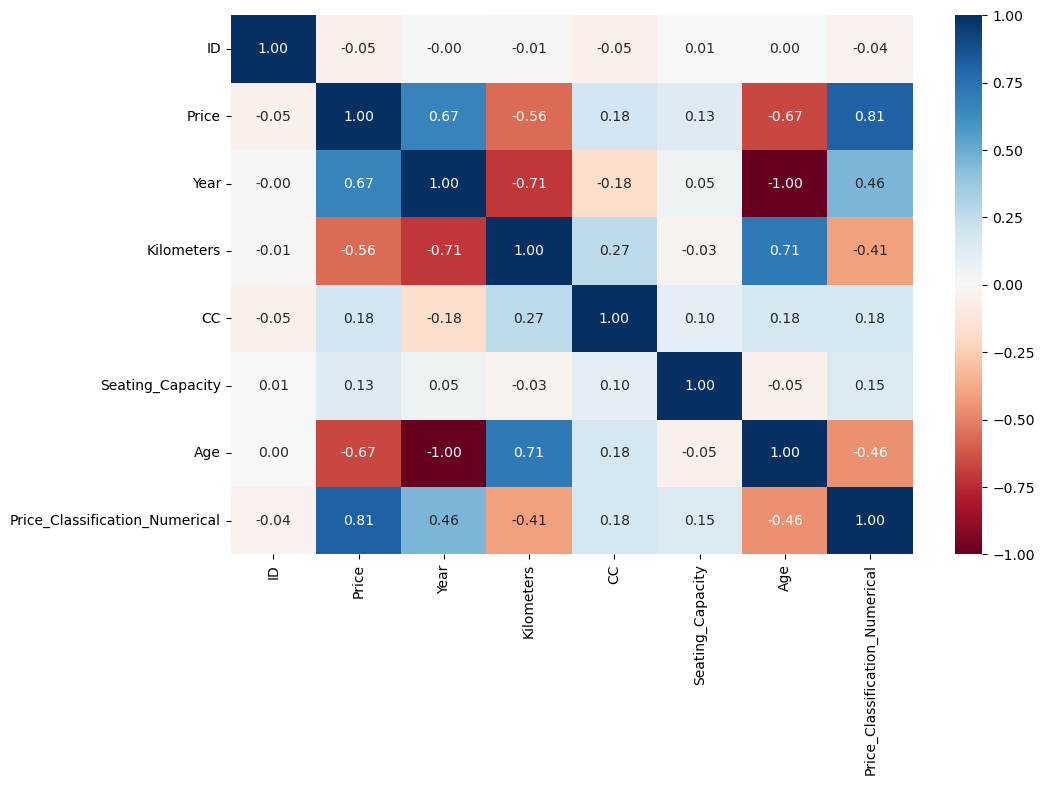

In [47]:
# Correlation Analysis
# Heatmap
corr = cars_df.corr()
fig, ax = plt.subplots()
fig.set_size_inches(11, 7)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="RdBu", center=0, ax=ax)

**Define predictors and outcome**

In [48]:
predictors = ['Brand', 'Kilometers', 'Type', 'Gearbox', 'Fuel', 'CC', 'Seating_Capacity','Age']
outcome = 'Price'
X = cars_df [predictors]
y = cars_df[outcome]

**Data pre-processing - encode categorical variables**

In [49]:
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

C:\Users\bente\AppData\Local\Temp\ipykernel_11856\3949794380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])


In [50]:
X.head(9)

,Brand,Kilometers,Type,Gearbox,Fuel,CC,Seating_Capacity,Age
0,50,263000.0,48,1,5,2362.0,5,13
1,35,120579.0,4,1,0,2143.0,4,13
2,19,72506.0,42,1,5,1796.0,5,7
3,38,121870.0,48,1,5,2488.0,5,6
4,11,154136.0,48,1,0,2720.0,5,7
5,3,117306.0,35,1,3,2497.0,5,12
6,23,231907.0,2,3,0,2999.0,2,8
7,11,64109.0,26,3,5,1596.0,5,10
8,21,84500.0,35,1,5,1796.0,5,10


In [51]:
y.head(9)

0     9999.0
1    34990.0
2    15990.0
3    26800.0
4    23990.0
5    18990.0
6    15490.0
7    12490.0
8    13500.0
Name: Price, dtype: float64

**Data partition**

In [52]:
train_X, valid_X, train_y, valid_y = train_test_split (X, y, test_size=0.4, random_state=1)

**Normalization**

In [53]:
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

C:\Users\bente\AppData\Local\Temp\ipykernel_11856\2430313679.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


In [54]:
X.head(9)

,Brand,Kilometers,Type,Gearbox,Fuel,CC,Seating_Capacity,Age
0,50,2.297176,48,1,5,0.004772,-0.107301,1.187704
1,35,0.213438,4,1,0,-0.329888,-1.019480,1.187704
2,19,-0.489910,42,1,5,-0.860148,-0.107301,-0.172185
3,38,0.232326,48,1,5,0.197316,-0.107301,-0.398833
4,11,0.704405,48,1,0,0.551841,-0.107301,-0.172185
5,3,0.165551,35,1,3,0.211069,-0.107301,0.961056
6,23,1.842260,2,3,0,0.978188,-2.843839,0.054463
7,11,-0.612765,26,3,5,-1.165774,-0.107301,0.507760
8,21,-0.314428,35,1,5,-0.860148,-0.107301,0.507760


**Variable selection - Exhaustive Search**

In [55]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model
def score_model(model, variables):
    pred_y = model.predict(train_X[list(variables)])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y , pred_y, model)
allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)
data = []
for result in results:
    model = result['model']
    variables = list(result['variables'])
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC':AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables)))

,n,r2adj,AIC,Age,Brand,CC,Fuel,Gearbox,Kilometers,Seating_Capacity,Type
0,1,0.448747,194492.597124,True,False,False,False,False,False,False,False
1,2,0.543815,192802.048654,True,False,False,True,False,False,False,False
2,3,0.601011,191605.950796,True,False,True,True,False,False,False,False
3,4,0.663837,190075.874072,True,False,True,True,False,True,False,False
4,5,0.667053,189990.972842,True,False,True,True,False,True,True,False
5,6,0.669152,189935.450827,True,True,True,True,False,True,True,False
6,7,0.669285,189932.857835,True,True,True,True,False,True,True,True
7,8,0.669315,189933.046185,True,True,True,True,True,True,True,True


**Variable selection - Backward Elimination**

In [56]:
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X [list(variables)], train_y)
    return model
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)
allVariables = train_X.columns
best_model, best_variables = backward_elimination(allVariables, train_model, score_model, verbose=True)
print(best_variables)
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))

Variables: Brand, Kilometers, Type, Gearbox, Fuel, CC, Seating_Capacity, Age
Start: score=189933.05
Step: score=189932.86, remove Gearbox
Step: score=189932.86, remove None
['Brand', 'Kilometers', 'Type', 'Fuel', 'CC', 'Seating_Capacity', 'Age']

Regression statistics

                      Mean Error (ME) : -68.8346
       Root Mean Squared Error (RMSE) : 9888.2154
            Mean Absolute Error (MAE) : 7385.7493
          Mean Percentage Error (MPE) : -5.3096
Mean Absolute Percentage Error (MAPE) : 32.0874


**Variable selection - Forward Selection**

In [57]:
# The initial model is the constatn model this requires special handling
# in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[list(variables)], train_y)
    return model
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)
best_model, best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Brand, Kilometers, Type, Gearbox, Fuel, CC, Seating_Capacity, Age
Start: score=199813.53, constant
Step: score=194492.60, add Age
Step: score=192802.05, add Fuel
Step: score=191605.95, add CC
Step: score=190075.87, add Kilometers
Step: score=189990.97, add Seating_Capacity
Step: score=189935.45, add Brand
Step: score=189932.86, add Type
Step: score=189932.86, add None
['Age', 'Fuel', 'CC', 'Kilometers', 'Seating_Capacity', 'Brand', 'Type']


**Variable selection - Stepwise**

In [58]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print(best_variables)

Variables: Brand, Kilometers, Type, Gearbox, Fuel, CC, Seating_Capacity, Age
Start: score=199813.53, constant
Step: score=194492.60, add Age
Step: score=192802.05, add Fuel
Step: score=191605.95, add CC
Step: score=190075.87, add Kilometers
Step: score=189990.97, add Seating_Capacity
Step: score=189935.45, add Brand
Step: score=189932.86, add Type
Step: score=189932.86, unchanged None
['Age', 'Fuel', 'CC', 'Kilometers', 'Seating_Capacity', 'Brand', 'Type']


**Algorithm 1 - Linear Regression**

**Regression Model Code**

In [59]:
# Built the Linear Model based on the training data
cars_lm = LinearRegression()
cars_lm.fit(train_X, train_y)

# print coefficients
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': cars_lm.coef_}))

          Predictor  coefficient
0             Brand    54.619033
1        Kilometers    -0.095292
2              Type    15.813280
3           Gearbox  -223.055852
4              Fuel -2471.210165
5                CC     7.541284
6  Seating_Capacity   787.023024
7               Age -1618.412516


**Evaluation - Linear Regression - Training Data Performance**

In [60]:
# print performance measures (training data)
regressionSummary(train_y, cars_lm.predict(train_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 9970.1507
            Mean Absolute Error (MAE) : 7436.5064
          Mean Percentage Error (MPE) : -4.7046
Mean Absolute Percentage Error (MAPE) : 33.2694


**Evaluation - Linear Regression - Validation Data Performance**

In [61]:
# Use predict() to make predictions on a new set
cars_lm_pred = cars_lm.predict(valid_X)
result = pd.DataFrame ({'Predicted': cars_lm_pred, 'Actual': valid_y, 'Residual': valid_y - cars_lm_pred})
print(result.head(20))

#print performace measures (validation data)
regressionSummary(valid_y, cars_lm.predict(valid_X))

          Predicted   Actual      Residual
3565   30992.381403  26995.0  -3997.381403
4080   25178.927715  19700.0  -5478.927715
4426   48814.993345  54990.0   6175.006655
8211   32243.557625  22850.0  -9393.557625
7001   29264.154273  21999.0  -7265.154273
9569    8859.188139   7550.0  -1309.188139
2226   38856.344668  37500.0  -1356.344668
13841  53235.339520  61910.0   8674.660480
1225   41439.966817  33999.0  -7440.966817
316    30025.161962  39990.0   9964.838038
9489   51552.237755  62990.0  11437.762245
10433  31356.757694  17995.0 -13361.757694
13956  32091.073942  26990.0  -5101.073942
11781  56651.663936  40500.0 -16151.663936
663    15020.690764  10990.0  -4030.690764
4970   37425.918108  69900.0  32474.081892
12808  28744.011586  25990.0  -2754.011586
5604   53267.709121  75987.0  22719.290879
4046   10104.378686  12995.0   2890.621314
7153   32952.865107  42888.0   9935.134893

Regression statistics

                      Mean Error (ME) : -70.2167
       Root Mean Squared

**Evaluation - Linear Regression - Validation Data Performance in Histogram**

<function matplotlib.pyplot.show(close=None, block=None)>

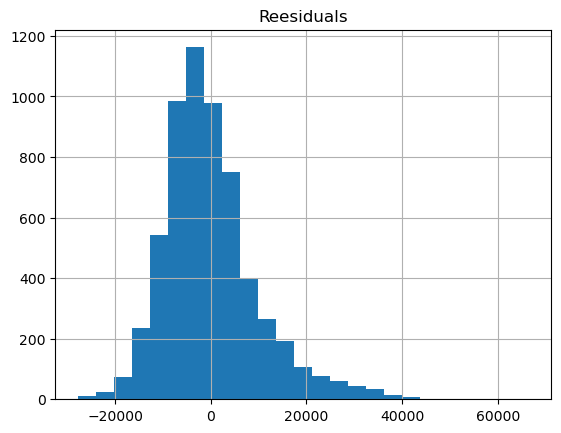

In [62]:
# Validation Error - Evaluate Perfomance
cars_lm_pred = cars_lm.predict(valid_X)
all_residuals = valid_y - cars_lm_pred

pd.DataFrame({'Reesiduals': all_residuals}).hist(bins=25)
plt.show

**Algorithm 2 - K-Nearest Neighbors (K-NN)**

**Change data type of outcome y**

In [63]:
outcome = 'Price_Classification_Numerical'
y = cars_df[outcome]

In [64]:
X.head(9)

,Brand,Kilometers,Type,Gearbox,Fuel,CC,Seating_Capacity,Age
0,50,2.297176,48,1,5,0.004772,-0.107301,1.187704
1,35,0.213438,4,1,0,-0.329888,-1.019480,1.187704
2,19,-0.489910,42,1,5,-0.860148,-0.107301,-0.172185
3,38,0.232326,48,1,5,0.197316,-0.107301,-0.398833
4,11,0.704405,48,1,0,0.551841,-0.107301,-0.172185
5,3,0.165551,35,1,3,0.211069,-0.107301,0.961056
6,23,1.842260,2,3,0,0.978188,-2.843839,0.054463
7,11,-0.612765,26,3,5,-1.165774,-0.107301,0.507760
8,21,-0.314428,35,1,5,-0.860148,-0.107301,0.507760


In [65]:
y.head(9)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
Name: Price_Classification_Numerical, dtype: int64

**Data partition**

In [66]:
train_X, valid_X, train_y, valid_y = train_test_split (X, y, test_size=0.4, random_state=1)

**Choosing k**

In [67]:
# Train a classifier for different values of k
k_values = range(1, 21)
accuracies_k = []
for k in k_values:
    # create a k-NN classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    accuracies_k.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })
# Convert accuracies to a pandas data frame
accuracies_k = pd.DataFrame(accuracies_k)
print(accuracies_k)

C:\Users\bente\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bente\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

     k  accuracy
0    1  0.912051
1    2  0.909533
2    3  0.915744
3    4  0.913729
4    5  0.916583
5    6  0.912555
6    7  0.912555
7    8  0.908694
8    9  0.908862
9   10  0.907687
10  11  0.909533
11  12  0.907016
12  13  0.904498
13  14  0.900302
14  15  0.903491
15  16  0.898456
16  17  0.899127
17  18  0.894763
18  19  0.897617
19  20  0.894931


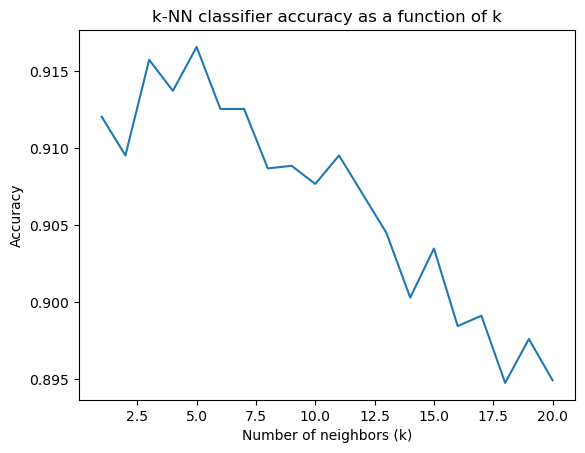

In [68]:
# Plot the accuracy as a function of k
plt.plot(accuracies_k['k'], accuracies_k['accuracy'])
plt.xlabel('Number of neighbors (k)')
plt.ylabel('Accuracy')
plt.title('k-NN classifier accuracy as a function of k')
plt.show()

In [69]:
# Print the optimal value of k
optimal_k = accuracies_k.loc[accuracies_k['accuracy'].idxmax()]['k']
print('Optimal k:', optimal_k)

Optimal k: 5.0


**Run k-NN**

In [70]:
# Train a k-NN classifier with the optimal value of k
knn = KNeighborsClassifier(n_neighbors=5).fit(train_X, train_y)

y_knn_valid_pred = knn.predict(valid_X)
y_knn_train_pred = knn.predict(train_X)

knn_proba = knn.predict_proba(valid_X)
knn_result = pd.DataFrame({'actual': valid_y,
                           'p(0)': [p[0] for p in knn_proba],
                           'p(1)': [p[1] for p in knn_proba],
                           'predicted': y_knn_valid_pred })

C:\Users\bente\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\bente\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdim

**Evaluation - KNN - Accuracy Rate**

In [71]:
accuracy_knn_train = accuracy_score(train_y, y_knn_train_pred)
accuracy_knn_valid = accuracy_score(valid_y, y_knn_valid_pred)
print(f"Training accuracy: {accuracy_knn_train:}")
print(f"Validation accuracy: {accuracy_knn_valid:}")

Training accuracy: 0.9446060877350044
Validation accuracy: 0.9165827458878818


**Evaluation - KNN - Confusion Matrix - Training Data**

In [72]:
cm_knn_train = classificationSummary(train_y, y_knn_train_pred)

Confusion Matrix (Accuracy 0.9446)

       Prediction
Actual    0    1
     0 6201  236
     1  259 2240


**Evaluation - KNN - Confusion Matrix - Validation Data**

In [73]:
cm_knn_valid = classificationSummary(valid_y, y_knn_valid_pred)

Confusion Matrix (Accuracy 0.9166)

       Prediction
Actual    0    1
     0 4024  236
     1  261 1437


**Algorithm 3 - Naïve Bayes Classifier**

**Data pre-processing - Naïve Bayes - change data type of input variables to categorical**

In [74]:
cars_df['CC_Classification'] = ['Small' if CC < 1201 else 'Medium' if CC >= 1201 and CC < 1401 else 'Large' 
                                for CC in cars_df['CC']]
cars_df['Kilometers_Category'] = ['Low' if Kilometers < 48280 else 'Medium' if Kilometers >= 48280 and Kilometers < 160000 else 'High' 
                               for Kilometers in cars_df['Kilometers']]
cars_df.Seating_Capacity = cars_df.Seating_Capacity.astype('category')
cars_df.Age = cars_df.Age.astype('category')

**Change data type of  predictors X from numerical to categorical without normalization**

In [75]:
predictors = ['Brand', 'Kilometers_Category', 'Type', 'Gearbox', 'Fuel', 'CC_Classification', 'Seating_Capacity','Age']
X = pd.get_dummies(cars_df[predictors])

In [76]:
X.head(9)

,Brand_Abarth,Brand_Alfa Romeo,Brand_Audi,Brand_BMW,Brand_Chery,Brand_Chrysler,Brand_Citroen,Brand_Cupra,Brand_Dodge,Brand_FPV,...,Age_25,Age_26,Age_27,Age_28,Age_29,Age_30,Age_31,Age_32,Age_33,Age_34
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Data partition**

In [77]:
train_X, valid_X, train_y, valid_y = train_test_split (X, y, test_size=0.4, random_state=1)

**Run Naïve Bayes**

In [78]:
# run naive Bayes
cars_nb = MultinomialNB(alpha=0.01)
cars_nb.fit(train_X, train_y)

# predict probabilities (Shows the belonging probabilities of each record to which class)
predProb_train = cars_nb.predict_proba(train_X)
predProb_valid = cars_nb.predict_proba(valid_X)

# predict class membership (shows the class instead of probability by selecting the class with highest probability)
y_nb_valid_pred = cars_nb.predict(valid_X)
y_nb_train_pred = cars_nb.predict(train_X)

nb_result = pd.DataFrame({'actual': valid_y,
                          'p(0)': [p[0] for p in predProb_valid],
                          'p(1)': [p[1] for p in predProb_valid],
                          'predicted': y_nb_valid_pred })

**Evaluation - Naïve Bayes - Accuracy Rate**

In [79]:
# Evaluate the classifier
accuracy_nb_train = accuracy_score(train_y, y_nb_train_pred)
accuracy_nb_valid = accuracy_score(valid_y, y_nb_valid_pred)
print(f"Training accuracy: {accuracy_nb_train:.4f}")
print(f"Validation accuracy: {accuracy_nb_valid:.4f}")

Training accuracy: 0.8834
Validation accuracy: 0.8822


**Evaluation - Naïve Bayes - Confusion Matrix - Training Data**

In [80]:
cm_nb_train = classificationSummary(train_y, y_nb_train_pred)

Confusion Matrix (Accuracy 0.8834)

       Prediction
Actual    0    1
     0 5947  490
     1  552 1947


**Evaluation - Naïve Bayes - Confusion Matrix - Validation Data**

In [81]:
cm_nb_valid = classificationSummary(valid_y, y_nb_valid_pred)

Confusion Matrix (Accuracy 0.8822)

       Prediction
Actual    0    1
     0 3935  325
     1  377 1321


**Algorithm 4 - Classification and Regression Trees**

**Change data type of predictors X as not all input variables are required to be categorical**

In [82]:
# Change data type of Seating_Capacity back to numerical
cars_df['Seating_Capacity'] = cars_df['Seating_Capacity'].astype('int64')
cars_df['Age'] = cars_df['Age'].astype('int64')

predictors = ['Brand', 'Kilometers', 'Type', 'Gearbox', 'Fuel', 'CC', 'Seating_Capacity','Age']
X = cars_df[predictors]

# Encode categorical variables
cat_cols = [col for col in X.columns if X[col].dtype == 'object']
label_encoder = LabelEncoder()
for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])
    
X.head(9)

C:\Users\bente\AppData\Local\Temp\ipykernel_11856\3856832599.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])


,Brand,Kilometers,Type,Gearbox,Fuel,CC,Seating_Capacity,Age
0,50,263000.0,48,1,5,2362.0,5,13
1,35,120579.0,4,1,0,2143.0,4,13
2,19,72506.0,42,1,5,1796.0,5,7
3,38,121870.0,48,1,5,2488.0,5,6
4,11,154136.0,48,1,0,2720.0,5,7
5,3,117306.0,35,1,3,2497.0,5,12
6,23,231907.0,2,3,0,2999.0,2,8
7,11,64109.0,26,3,5,1596.0,5,10
8,21,84500.0,35,1,5,1796.0,5,10


In [83]:
X.dtypes

Brand                 int32
Kilometers          float64
Type                  int32
Gearbox               int32
Fuel                  int32
CC                  float64
Seating_Capacity      int64
Age                   int64
dtype: object

**Data partition**

In [84]:
train_X, valid_X, train_y, valid_y = train_test_split (X, y, test_size=0.4, random_state=1)

**Decision Tree Classifier**

In [85]:
classTree = DecisionTreeClassifier(random_state=1, max_depth=3)
classTree.fit(train_X, train_y)

y_dt_valid_pred = classTree.predict(valid_X)
y_dt_train_pred = classTree.predict(train_X)

dt_proba = classTree.predict_proba(valid_X)
dt_result = pd.DataFrame({'actual': valid_y,
                          'p(0)': [p[0] for p in dt_proba],
                          'p(1)': [p[1] for p in dt_proba],
                          'predicted': y_dt_valid_pred })

**Plotting the tree**

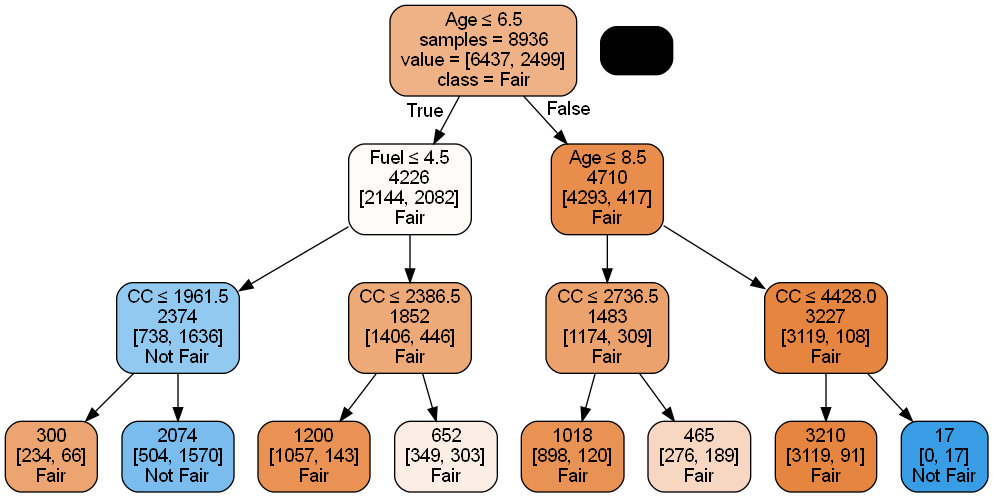

In [86]:
plotDecisionTree(classTree, feature_names=X.columns, class_names=['Fair', 'Not Fair'])

**Evaluation - Classification and Regression Trees - Accuracy Rate**

In [87]:
# Evaluate the classifier
accuracy_dt_train = accuracy_score(train_y, y_dt_train_pred)
accuracy_dt_valid = accuracy_score(valid_y, y_dt_valid_pred)
print(f"Training accuracy: {accuracy_dt_train:.4f}")
print(f"Validation accuracy: {accuracy_dt_valid:.4f}")

Training accuracy: 0.8415
Validation accuracy: 0.8406


**Evaluation - Classification and Regression Trees - Confusion Matrix - Training Data**

In [88]:
cm_dt_train = classificationSummary(train_y, y_dt_train_pred)

Confusion Matrix (Accuracy 0.8415)

       Prediction
Actual    0    1
     0 5933  504
     1  912 1587


**Evaluation - Classification and Regression Trees - Confusion Matrix - Validation Data**

In [89]:
cm_dt_valid = classificationSummary(valid_y, y_dt_valid_pred)

Confusion Matrix (Accuracy 0.8406)

       Prediction
Actual    0    1
     0 3925  335
     1  615 1083


**Algorithm 5 - Logistic Regression**

**Normalization**

In [90]:
num_cols = [col for col in X.columns if X[col].dtype in ['int64', 'float64']]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

X.head(9)

C:\Users\bente\AppData\Local\Temp\ipykernel_11856\2473021236.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = scaler.fit_transform(X[num_cols])


,Brand,Kilometers,Type,Gearbox,Fuel,CC,Seating_Capacity,Age
0,50,2.297176,48,1,5,0.004772,-0.107301,1.187704
1,35,0.213438,4,1,0,-0.329888,-1.019480,1.187704
2,19,-0.489910,42,1,5,-0.860148,-0.107301,-0.172185
3,38,0.232326,48,1,5,0.197316,-0.107301,-0.398833
4,11,0.704405,48,1,0,0.551841,-0.107301,-0.172185
5,3,0.165551,35,1,3,0.211069,-0.107301,0.961056
6,23,1.842260,2,3,0,0.978188,-2.843839,0.054463
7,11,-0.612765,26,3,5,-1.165774,-0.107301,0.507760
8,21,-0.314428,35,1,5,-0.860148,-0.107301,0.507760


**Data partition**

In [91]:
train_X, valid_X, train_y, valid_y = train_test_split (X, y, test_size=0.4, random_state=1)

**Fit using logistic regression**

In [92]:
# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg = LogisticRegression(penalty="l2", C=1e42)
logit_reg.fit(train_X , train_y)

logit_reg_valid_pred = logit_reg.predict(valid_X)
logit_reg_train_pred = logit_reg.predict(train_X)
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_result = pd.DataFrame({'actual': valid_y,
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_valid_pred })

print('intercept', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print()
print('AIC', AIC_score(valid_y , logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept -1.077727671998732
          Brand  Kilometers      Type   Gearbox      Fuel        CC  \
coeff  0.004781   -1.467431  0.005732 -0.050226 -0.598894  1.117838   

       Seating_Capacity      Age  
coeff          0.319352 -2.09214  


AIC 4690.802235479121


C:\Users\bente\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**Evaluation - Logistic Regression - Accuracy Rate**

In [93]:
accuracy_logit_reg_train = accuracy_score(train_y, logit_reg_train_pred)
accuracy_logit_reg_valid_pred = accuracy_score(valid_y, logit_reg_valid_pred)
print(f"Training accuracy: {accuracy_logit_reg_train:.4f}")
print(f"Validation accuracy: {accuracy_logit_reg_valid_pred:.4f}")

Training accuracy: 0.8639
Validation accuracy: 0.8718


**Evaluation - Logistic Regression - Confusion Matrix - Training Data**

In [94]:
cm_lr_train = classificationSummary(train_y, logit_reg_train_pred)

Confusion Matrix (Accuracy 0.8639)

       Prediction
Actual    0    1
     0 5952  485
     1  731 1768


**Evaluation - Logistic Regression - Confusion Matrix - Validation Data**

In [95]:
cm_lr_valid = classificationSummary(valid_y, logit_reg_valid_pred)

Confusion Matrix (Accuracy 0.8718)

       Prediction
Actual    0    1
     0 3947  313
     1  451 1247


**Comparison between classification algorithms - Bar Chart**

C:\Users\bente\AppData\Local\Temp\ipykernel_11856\2308423886.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


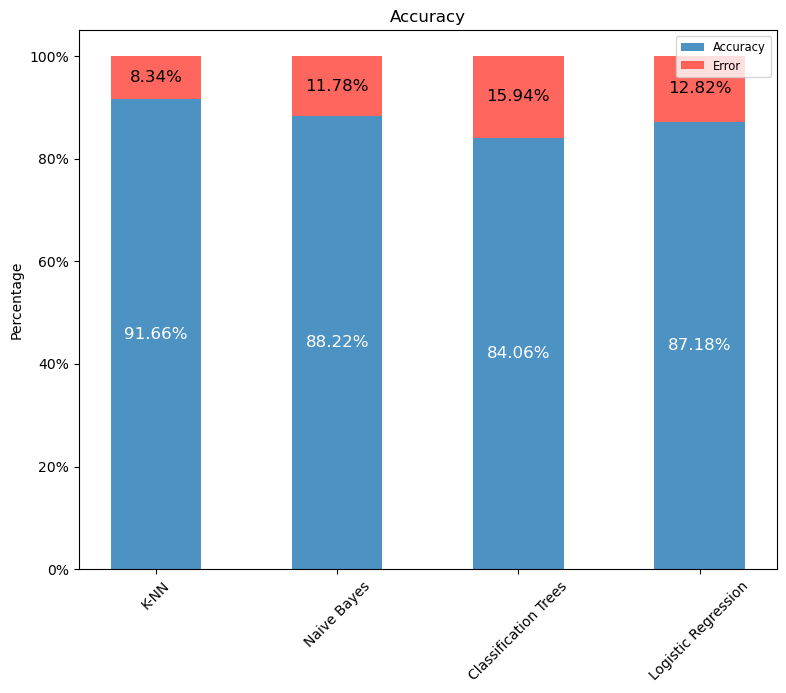

In [96]:
error_knn = 1 - accuracy_knn_valid
error_nb = 1 - accuracy_nb_valid
error_dt = 1 - accuracy_dt_valid
error_logit_reg = 1 - accuracy_logit_reg_valid_pred

labels = ['K-NN', 'Naive Bayes', 'Classification Trees', 'Logistic Regression']
accuracy = [accuracy_knn_valid, accuracy_nb_valid, accuracy_dt_valid, accuracy_logit_reg_valid_pred]
error = [error_knn, error_nb, error_dt, error_logit_reg]

accuracy_color = '#1f77b4'
error_color = '#ff4136'

bar_width = 0.5
fig, ax = plt.subplots(figsize=(9, 7))
ax.bar(labels, accuracy, bar_width, color=accuracy_color, alpha=0.8, label='Accuracy')
ax.bar(labels, error, bar_width, color=error_color, alpha=0.8, bottom=accuracy, label='Error')

ax.set_ylabel('Percentage')
ax.set_title('Accuracy')
ax.legend()

for i, v in enumerate(accuracy):
    ax.text(i, v/2, '{:.2f}%'.format(v*100), ha='center', va='center', color='white', fontsize=12)
for i, v in enumerate(error):
    ax.text(i, v/2+accuracy[i], '{:.2f}%'.format(v*100), ha='center', va='center', color='black', fontsize=12)

ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.legend(loc='upper right', fontsize='small')
ax.set_xticklabels(labels, rotation=45)

plt.show()

**Comparison between classification algorithms - Gains Chart**

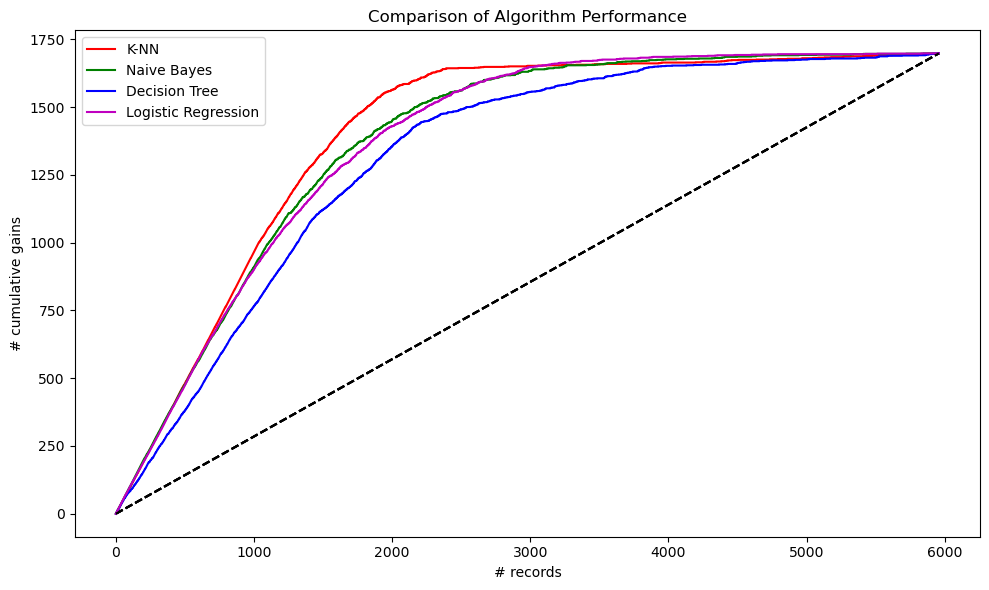

In [97]:
KNN_df = knn_result.sort_values(by=['p(1)'], ascending=False)
NB_df = nb_result.sort_values(by=['p(1)'], ascending=False)
DT_df = dt_result.sort_values(by=['p(1)'], ascending=False)
Logit_df = logit_result.sort_values(by=['p(1)'], ascending=False)

for df in [KNN_df, NB_df, DT_df, Logit_df]:
    df['actual'] = pd.to_numeric(df['actual'])

results = [(KNN_df, 'K-NN', 'r'),
           (NB_df, 'Naive Bayes', 'g'),
           (DT_df, 'Decision Tree', 'b'),
           (Logit_df, 'Logistic Regression', 'm')]

fig, ax = plt.subplots(figsize=(10, 6))

for result in results:
    df, label, color = result   # extract the color from the results tuple
    df = df.sort_values(by=['p(1)'], ascending=False)
    x = gainsChart(df.actual, ax=ax, label=label, color=color)  # pass the color to gainsChart
    
ax.set_title('Comparison of Algorithm Performance')
ax.legend()
plt.tight_layout()
plt.show()